# Quantum implementation - Variational Quantum Classifier (VQC)

References:
* https://arxiv.org/pdf/2505.17756
* https://arxiv.org/pdf/1804.11326

Qiskit Machine Learning references (NOT working with latest Qiskit 2.0 package, so we don't use it today)
* https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html

In [24]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit.result import QuasiDistribution

In [25]:
iris_data = load_iris()

In [26]:
features = iris_data.data
features = MinMaxScaler().fit_transform(features) #Normalization of features to [0,1]

labels = iris_data.target

In [27]:
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

In [28]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, train_size=0.8, random_state=123)

### We need to construct feature map - which will store our classical data as gate parameters:

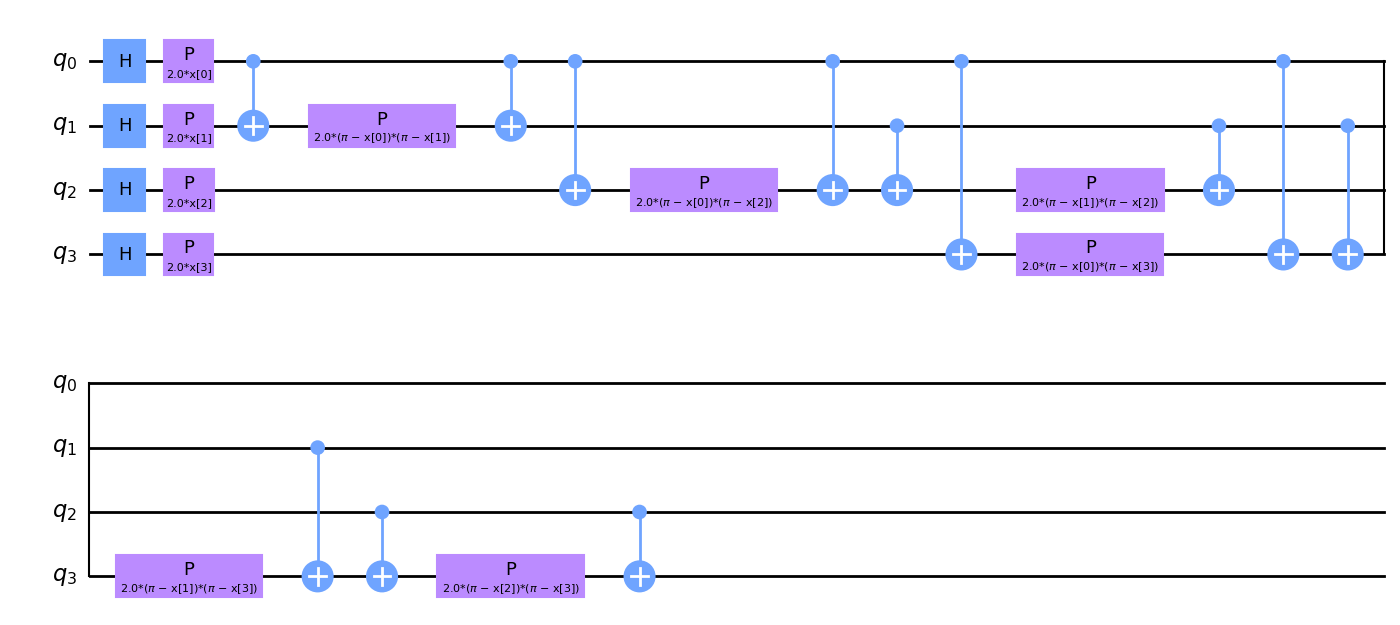

In [29]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

### Now let's create the anzats - being our quantum neural network which we need to train:

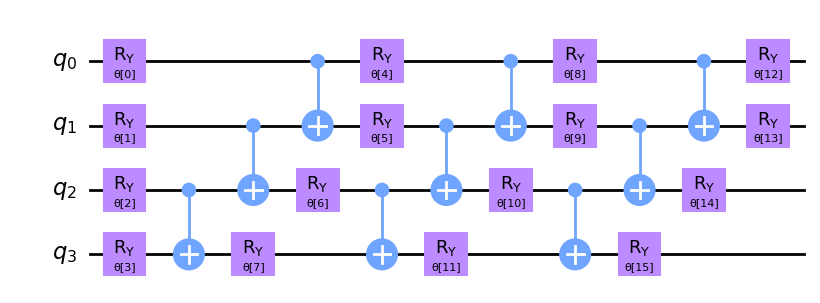

In [30]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

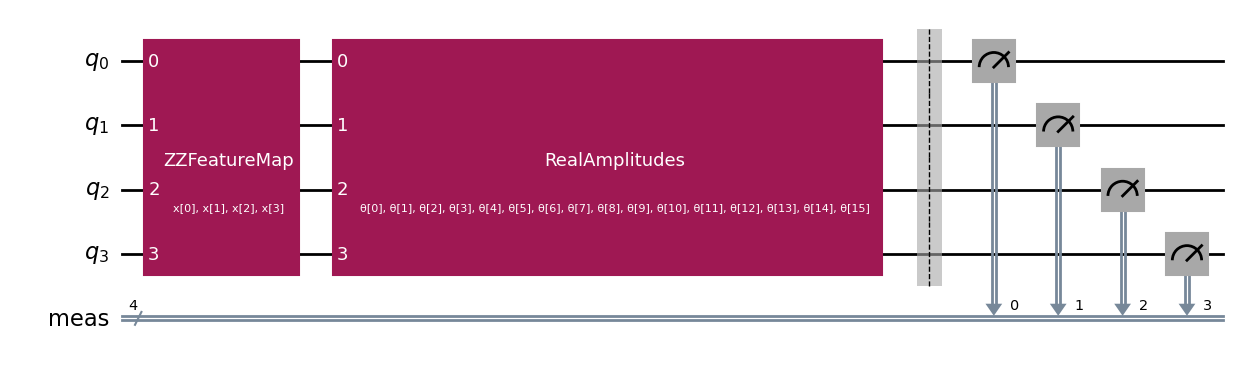

In [31]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(num_features)
circuit.compose(feature_map, inplace=True)
circuit.compose(ansatz, inplace=True)
circuit.measure_all()

circuit.draw('mpl')

In [32]:
from qiskit.transpiler import generate_preset_pass_manager
 
pm = generate_preset_pass_manager(optimization_level=3)
isa_circuit = pm.run(circuit)

In [33]:
import numpy as np
num_thetas = circuit.num_parameters - circuit.num_qubits
initial_thetas = 0.5* np.pi * np.random.random(num_thetas)
print(initial_thetas)

[0.57599444 0.52530306 1.11554811 1.29158685 0.53185366 1.28927858
 0.11996829 0.7944167  0.39528254 1.53420035 1.01588514 0.75990897
 0.16447669 1.05281803 1.55569065 0.41809903]


In [34]:
def cost_function(thetas, circuit, sampler):
    cost = 0
    num_shots=10000
    point_number=0
    for X in train_features:
        params = np.concatenate((X, thetas))
        sampler = StatevectorSampler()
        pub = (circuit, params)
        job = sampler.run([pub], shots=num_shots)
        counts = job.result()[0].data.meas.get_counts()
        
        # Convert to quasi-probabilities
        counts_normalized = {k: v / num_shots for k, v in counts.items()}
        probabilities = QuasiDistribution(counts_normalized)
        probabilities = {k: v for k, v in probabilities.items() if int(k) < 2**circuit.num_qubits}

        #counts:
        #  {'1011': 1685, '0101': 513, '1000': 1251, '0010': 1158, '0100': 1732, '0111': 1079, '1111': 500, '1010': 266, '1110': 210, '1101': 292, '0000': 176, '0110': 70, '1001': 356, '1100': 43, '0011': 546, '0001': 123}
        #counts_normalized:
        #  {'1011': 0.1685, '0101': 0.0513, '1000': 0.1251, '0010': 0.1158, '0100': 0.1732, '0111': 0.1079, '1111': 0.05, '1010': 0.0266, '1110': 0.021, '1101': 0.0292, '0000': 0.0176, '0110': 0.007, '1001': 0.0356, '1100': 0.0043, '0011': 0.0546, '0001': 0.0123}
        #probabilities:
        #  {11: 0.1685, 5: 0.0513, 8: 0.1251, 2: 0.1158, 4: 0.1732, 7: 0.1079, 15: 0.05, 10: 0.0266, 14: 0.021, 13: 0.0292, 0: 0.0176, 6: 0.007, 9: 0.0356, 12: 0.0043, 3: 0.0546, 1: 0.0123}

        cost = cost + (1.0 - probabilities.get(train_labels[point_number],0.0))
        point_number = point_number + 1
    print(cost)
    cost_values.append(cost)
    return cost

In [35]:
from qiskit.primitives import StatevectorSampler
from scipy.optimize import minimize

cost_values = []

sampler = StatevectorSampler()

result = minimize(
    cost_function,
    initial_thetas,
    args=(isa_circuit, sampler),
    method="COBYLA",
    tol=1e-2)

print(result)

112.90510000000003
112.77770000000002
112.84510000000003
112.80949999999999
113.84450000000004
113.27129999999998
111.71670000000006
108.36610000000003
107.6568
110.34920000000001
110.93450000000006
108.90539999999994
107.44419999999998
110.26480000000001
108.02890000000002
109.72269999999999
108.5769
105.72169999999998
109.22519999999999
105.62879999999994
106.3816
105.78029999999998
108.71530000000003
105.62460000000004
102.61030000000004
103.07659999999997
102.60520000000002
101.39219999999999
108.03160000000004
100.42670000000003
105.31690000000003
102.06019999999994
96.63539999999993
96.29140000000004
95.67589999999998
96.41969999999999
97.23030000000001
96.7847
98.48330000000003
94.2834
98.02759999999996
97.14150000000002
97.25419999999997
96.91840000000002
96.87369999999999
96.43299999999999
101.76399999999994
95.86580000000004
94.96770000000001
93.6805
94.36850000000001
93.7001
93.89589999999997
93.6223
94.7397
95.67550000000004
92.92719999999997
92.1881
93.38290000000006
91.55

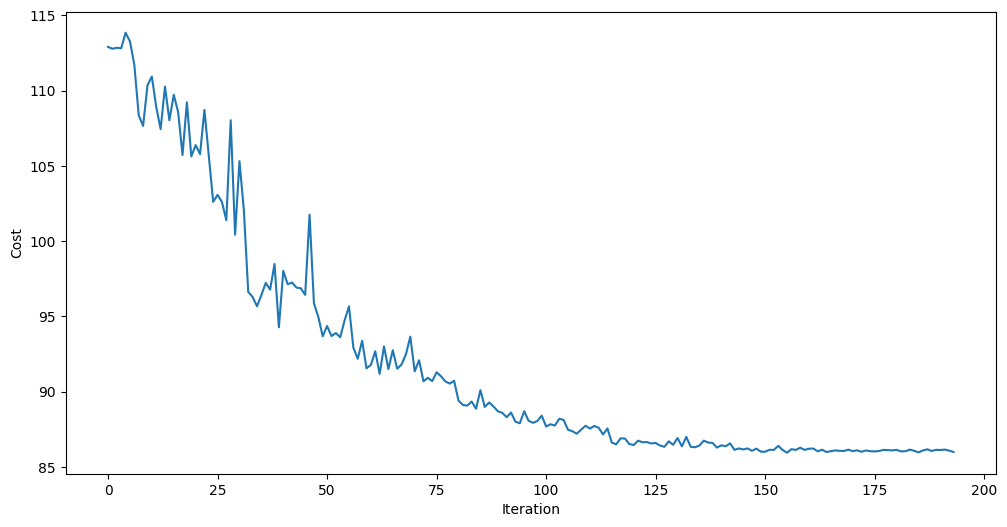

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(cost_values)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [41]:
def classify(features, thetas):
    num_shots=10000
    params = np.concatenate((features, thetas))
    sampler = StatevectorSampler()
    pub = (circuit, params)
    job = sampler.run([pub], shots=num_shots)
    counts = job.result()[0].data.meas.get_counts()
        
    counts_normalized = {k: v / num_shots for k, v in counts.items()}
    probabilities = QuasiDistribution(counts_normalized)
    probabilities = {k: v for k, v in probabilities.items() if int(k) < 2**circuit.num_qubits}

    #Extracting just probabilities of the 3 classes (ignoring the rest):
    small_dictionary = {0:probabilities.get(0, 0.0), 1:probabilities.get(1, 0.0), 2:probabilities.get(2, 0.0)}
    classification = max(small_dictionary, key=small_dictionary.get)
    return classification

### Checking score on training set:

In [42]:
point_number=0
correct_classifications=0
for features in train_features:
    y = classify(features, result.x)
    #print(y, train_labels[point_number])
    if(y == train_labels[point_number]): correct_classifications = correct_classifications + 1
    point_number = point_number+1

score = correct_classifications / (point_number + 1)
print(score)

0.7024793388429752


### Checking score on test set:

In [39]:
point_number=0
correct_classifications=0
for features in test_features:
    y = classify(features, result.x)
    if(y == test_labels[point_number]): correct_classifications = correct_classifications + 1
    point_number = point_number+1

score = correct_classifications / (point_number + 1)
print(score)

0.7741935483870968
